# Colorbar Demo Notebook: skip to the last section for the demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import salishsea_tools.river_202108 as rivers

In [2]:
# sample data from one of my research runs
fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/dye_tracers/extractions/SalishSeaCast_river_trace_day_avg_river_tracers_test_20230301_20230302.nc')

In [5]:
gridY = fw_rivers.nooksack_river['gridY'].values
gridX = fw_rivers.nooksack_river['gridX'].values

In [6]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0][:, min(gridY):max(gridY)+1, min(gridX):max(gridX)+1]

In [7]:
fudge = .0001 # need to add very small number here because we can't do log of zero without weird effects in the masking

In [8]:
total_freshwater = fw_rivers.nooksack_river + fw_rivers.skagit_river + fw_rivers.snohomish_river + fw_rivers.nisqually_river + fw_rivers.elwha_river + \
    fw_rivers.cowichan_river + fw_rivers.nanaimo_river + fw_rivers.puntledge_river + fw_rivers.salmon_river + fw_rivers.homathko_river + \
    fw_rivers.squamish_river + fw_rivers.other_rivers + fw_rivers.fraser_river

Nooksack_proportion = fw_rivers.nooksack_river/total_freshwater

## Cbar Contour Line Demo

Modified code showing how I put the line on my contours.

I used matplotlib.pyplot.contour() to draw the line on the plot and stored the object as cont1. 

I used matplotlib.pyplot.colorbar() to add the colorbar and stored the object as cbar.

To draw the contour line on the colorbar, I said cbar.add_lines(cont1).

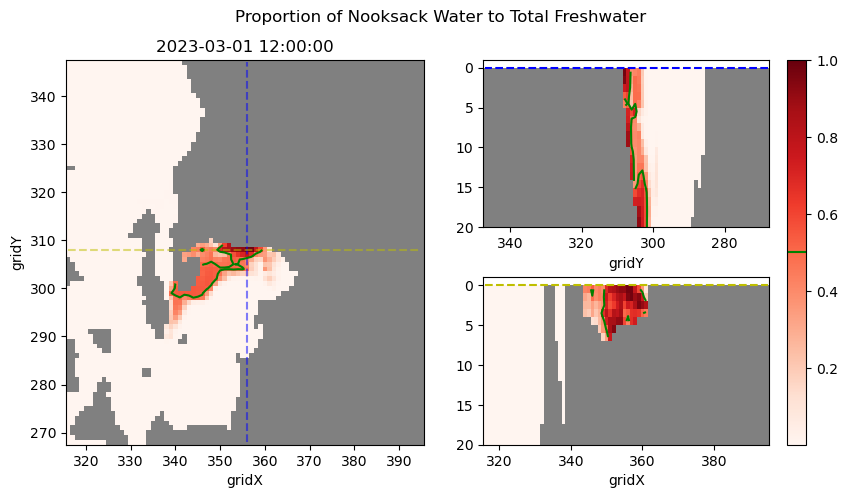

In [9]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Proportion of Nooksack Water to Total Freshwater')

grid = plt.GridSpec(2,4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0:,0:2])
ax2 = plt.subplot(grid[0,2:])
ax3 = plt.subplot(grid[1,2:])

depth = 0
tstep = 0
cont_level = 0.5
cmap = mpl.colormaps['Reds']
cmap.set_bad('gray')

## finding vmax
# dye_max = np.nanmax(Nooksack_proportion[:, :, :, :].values)  # for raw volumes
dye_max = 1  # for proportions

## axs1
freshwater1 = np.ma.masked_array(Nooksack_proportion[tstep, depth], mask=tmask[0])
X1 = gridX
Y1 = gridY
Z1 = freshwater1 + fudge
colours1 = ax1.pcolormesh(X1, Y1, Z1, vmin=fudge, vmax=dye_max, cmap=cmap)  # plot the pcolormesh of gridX, gridY, and masked dye values
ax1.plot([rivers.prop_dict['fraser']['Nooksack']['j'], rivers.prop_dict['fraser']['Nooksack']['j']], [gridY[0], gridY[-1]], 'b--', alpha=0.5)  # add the lines to show the slices
ax1.plot([gridX[0], gridX[-1]], [rivers.prop_dict['fraser']['Nooksack']['i'], rivers.prop_dict['fraser']['Nooksack']['i']], 'y--', alpha=0.5)
cont1 = ax1.contour(X1, Y1, Z1, [cont_level], colors='green')  # define the contour object for this axis
ax1.set_title(str(pd.to_datetime(fw_rivers['time'].values[0])))
ax1.set_xlabel('gridX')
ax1.set_ylabel('gridY')

## axs2
freshwater2 = np.ma.masked_array(Nooksack_proportion[tstep, :, :, rivers.prop_dict['fraser']['Nooksack']['j']-min(gridX)], mask=tmask[:, :, rivers.prop_dict['fraser']['Nooksack']['j']-min(gridX)])
X2 = gridY
Y2 = fw_rivers.depth
Z2 = freshwater2 + fudge
colours2 = ax2.pcolormesh(X2, Y2, Z2, vmin=fudge, vmax=dye_max, cmap=cmap)
ax2.plot([gridY[0], gridY[-1]],[0,0],'b--')
cont2 = ax2.contour(X2, Y2, Z2, [cont_level], colors='green')
ax2.set_ylim(-1, 20)
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_xlabel('gridY')

## axs3
freshwater3 = np.ma.masked_array(Nooksack_proportion[tstep, :, rivers.prop_dict['fraser']['Nooksack']['i']-min(gridY), :], mask=tmask[:, rivers.prop_dict['fraser']['Nooksack']['i']-min(gridY), :])
X3 = gridX
Y3 = fw_rivers.depth
Z3 = freshwater3 + fudge
colours3 = ax3.pcolormesh(X3, Y3, Z3, vmin=fudge, vmax=dye_max, cmap=cmap)
ax3.plot([gridX[0], gridX[-1]],[0,0],'y--')
cont3 = ax3.contour(X3, Y3, Z3, [cont_level], colors='green')
ax3.set_ylim(-1, 20)
ax3.invert_yaxis()
ax3.set_xlabel('gridX')

## call back to the first pcolormesh to create the colorbar; since vmin and vmax set for all plots, will represent all values.
## tell matplotlib to put the colorbar spanning axis 2 and 3
cbar = fig.colorbar(colours1, ax=[ax2, ax3])
cbar.add_lines(cont1)  # add the contour line to the colorbar. this single line of code should work for multiple contours contained in the same object